# Combining Dirichlet and Neumann conditions
Author: Jørgen S. Dokken

Let's return to the Poisson problem from the [Fundamentals chapter](./../chapter1/fundamentals.md) and see how to extend the mathematics and the implementation to handle Dirichlet condition in combination with a Neumann condition.
The domain is still the unit square, but now we set the Dirichlet condition $u=u_D$ at the left and right sides, while the Neumann condition 

$$
-\frac{\partial u}{\partial n}=g
$$

is applied to the  remaining sides $y=0$ and $y=1$.

## The PDE problem
Let $\Lambda_D$ and $\Lambda_N$ denote parts of the boundary $\partial \Omega$ where the Dirichlet and Neumann conditions apply, respectively.
The complete boundary-value problem can be written as

$$
-\nabla^2 u =f \qquad \text{in } \Omega,
$$
$$
u=u_D \qquad\text{on } \Lambda_D,
$$
$$
-\frac{\partial u}{\partial n}=g \qquad \text{on }\Lambda_N
$$

Again, we choose $u=1+x^2+2y^2$ as the exact solution and adjust $f, g,$ and $u_D$ accordingly

$$
f(x,y)=-6,
$$
$$
g(x,y)=\begin{cases}
0, & y=0,\\
-4, & y=1,
\end{cases}
$$
$$
u_D(x,y)=1+x^2+2y^2.
$$

For the ease of programming, we define $g$ as a function over the whole domain $\Omega$ such that $g$ takes on the correct values at $y=0$ and $y=1$. One possible extension is
$$
 g(x,y)=-4y.
$$
## The variational formulation
The first task is to derive the variational formulatin. This time we cannot omit the boundary term arising from integration by parts, because $v$ is only zero on $\Lambda_D$. We have

$$
-\int_\Omega (\nabla^2u)v~\mathrm{d} x = \int_\Omega \nabla u \cdot \nabla v ~\mathrm{d} x - \int_{\partial\Omega}\frac{\partial u}{\partial n}v~\mathrm{d}s,
$$

and since $v=0$ on $\Lambda_D$,

$$
- \int_{\partial\Omega}\frac{\partial u}{\partial n}v~\mathrm{d}s= - \int_{\Lambda_N}\frac{\partial u}{\partial n}v~\mathrm{d}s =\int_{\Lambda_N} gv~\mathrm{d}s,
$$

by applying the boundary condition on $\Lambda_N$.
The resulting weak from reads

$$
    \int_\Omega \nabla u \cdot \nabla v~\mathrm{d} x = \int_\Omega fv~\mathrm{d} x - \int_{\Lambda_N}gv~\mathrm{d}s.
$$
Expressing this equation in the standard notation $a(u,v)=L(v)$ is straight-forward with 

$$
    a(u,v) = \int_{\Omega} \nabla u \cdot \nabla v ~\mathrm{d} x,\\
$$
$$
L(v) = \int_{\Omega} fv ~\mathrm{d} x - \int_{\Lambda_N} gv~\mathrm{d} s.
$$

## Implementation
As in the previous example, we define our mesh,function space and bilinear form $a(u,v)$.

In [4]:
import numpy as np

from dolfinx.fem import (Constant, Function, FunctionSpace, 
                         assemble_scalar, dirichletbc, form, locate_dofs_geometrical)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.mesh import create_unit_square
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
from ufl import SpatialCoordinate, TestFunction, TrialFunction, dot, ds, dx, grad

mesh = create_unit_square(MPI.COMM_WORLD, 10, 10)
V = FunctionSpace(mesh, ("CG", 1))
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v)) * dx

Now we get to the Neumann and Dirichlet boundary condition. As previously, we use a Python-function to define the boundary where we should have a Dirichlet condition. Then, with this function, we locate degrees of freedom that fullfils this condition. 

In [5]:
def u_exact(x):
    return 1 + x[0]**2 + 2*x[1]**2

def boundary_D(x):
    return np.logical_or(np.isclose(x[0], 0), np.isclose(x[0],1))

dofs_D = locate_dofs_geometrical(V, boundary_D)
u_bc = Function(V)
u_bc.interpolate(u_exact)
bc = dirichletbc(u_bc, dofs_D)

The next step is to define the Neumann condition. We first define $g$ uses `UFL`s `SpatialCoordinate`-function, and then in turn create a boundary integration measure `ds`. As the test function $v$ is zero on the boundary integrals over the Dirichlet boundary dissapears, and wee can integrate `g*v*ds` over the entire boundary.

In [6]:
x = SpatialCoordinate(mesh)
g = -4 * x[1]
f = Constant(mesh, ScalarType(-6))
L = f * v * dx - g * v * ds

We can now assemble and solve the linear system of equations 

In [7]:
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

V2 = FunctionSpace(mesh, ("CG", 2))
uex = Function(V2)
uex.interpolate(u_exact)
error_L2 = assemble_scalar(form((uh - uex)**2 * dx))
error_L2 = np.sqrt(MPI.COMM_WORLD.allreduce(error_L2, op=MPI.SUM))

u_vertex_values = uh.x.array
uex_1 = Function(V)
uex_1.interpolate(uex)
u_ex_vertex_values = uex_1.x.array
error_max = np.max(np.abs(u_vertex_values - u_ex_vertex_values))
error_max = MPI.COMM_WORLD.allreduce(error_max, op=MPI.MAX)
print(f"Error_L2 : {error_L2:.2e}")
print(f"Error_max : {error_max:.2e}")

Error_L2 : 5.27e-03
Error_max : 2.44e-15


In [10]:
uex = Function(V)
uex.interpolate(u_exact)

In [11]:
import matplotlib.pyplot as plt
def data_construct(geometry, x_array):
    data = np.column_stack((geometry[:, 0:2], x_array))
    x_data = data[:, 0]
    y_data = data[:, 1]
    z_data = data[:, 2]
    return [x_data, y_data, z_data]

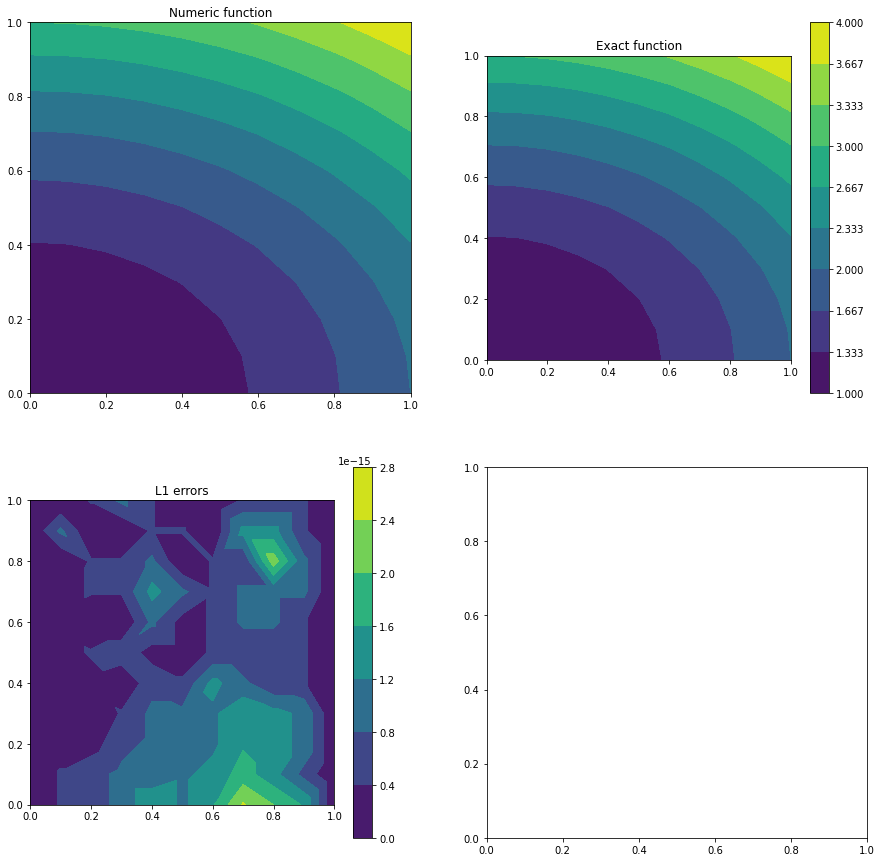

In [12]:
geometry = mesh.geometry.x
levels = np.linspace(uh.x.array.min(), uh.x.array.max(), 10)

fig, ((ax_sol, ax_d), (ax_er, ax_1)) = plt.subplots(2, 2)
fig.set_size_inches(15, 15)

ax_sol.set_title('Numeric function')
ax_sol.tricontourf(*data_construct(geometry, uh.x.array), levels=levels)

ax_d.set_title('Exact function')
ax0 = ax_d.tricontourf(*data_construct(geometry, uex.x.array), levels=levels)
fig.colorbar(ax0, ax=ax_d)
ax_d.set_aspect(1)

ax_er.set_title('L1 errors')
a1 = ax_er.tricontourf(
    *data_construct(geometry, np.abs(uh.x.array - uex.x.array))
    )
ax_er.set_aspect(1)
fig.colorbar(a1, ax=ax_er)